In [2]:
import local_seqtools.general_utils as tools
import pandas as pd
import numpy as np
import local_conservation_analysis_pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"

# %load_ext autoreload
# %autoreload 2

# import score tables

In [3]:
def table_file_converter(table_file):
    return table_file.replace('/home/jch/Documents/07-pt1_pt2_combined', '..')

In [4]:
score_key_file = '../benchmark/benchmark_v3/p3_conservation/wide_form_tables_with_scores_v3/score_key.csv'
score_key = pd.read_csv(score_key_file)
colmap = {
    'aln_property_entropy': 'property_entropy',
    'aln_shannon_entropy': 'shannon_entropy'
}
for i, row in score_key.iterrows():
    if row['score_key'] in colmap:
        score_key.at[i, 'columnwise_score_function_name'] = colmap[row['score_key']]

score_key = score_key.fillna('MSA')

def get_num_passing(table_file, score_key='hit_z_scores', filename_converter=None):
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    df = pd.read_csv(table_file)
    return (~df[score_key].isna()).sum()

score_key['num_passing'] = score_key['table_file'].apply(get_num_passing, filename_converter=table_file_converter)

In [5]:
score_key.head(10)

,score_index,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2362
1,1.0,MSA - MAFFT,Tetrapoda,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2362
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
3,3.0,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2524
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2343
5,5.0,MSA - MAFFT,Metazoa,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2343
6,6.0,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,shannon_entropy,1.0,2445
7,7.0,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,shannon_entropy,1.0,2541
8,8.0,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2445
9,9.0,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2541


# filtering

## removing Eukaryota 
Too many sequences get removed from the Eukaryota level when using MSA (because of the number of gaps in the alignment), so I will remove the eukaryota level from the Alignment.
Note that the scores of both methods drop when going from Metazoa to Euakryota, but the pairwise still performs better than the MSA.

In [6]:
score_key_filt = score_key[score_key['level']!='Eukaryota'].copy()

## removing similarity threshold = 0.5
We don't end up using this variant of the method in the final analysis and I think it might be a biased approach anyway.
It might be removed from the entire tool

In [7]:
score_key_filt=score_key_filt[score_key_filt['similarity_threshold']!=0.5]

## removing shannon entropy

In [8]:
score_key_filt=score_key_filt[score_key_filt['columnwise_score_function_name']=='property_entropy']

## remove alternate matrices and more unusual flank sizes

In [9]:
score_key_filt = score_key_filt[
    ~score_key_filt["score_key"].isin(
        [
            "fragpair_gapless_lf2_rf2_edssmat50",
            "fragpair_gapless_lf5_rf5_blosum62",
            "fragpair_gapless_lf10_rf10_edssmat50",
            "fragpair_gapless_lf0_rf0_grantham",
            "fragpair_gapless_lf0_rf0_blosum62",
        ]
    )
]

In [10]:
score_key_filt.score_key.unique()

array(['aln_property_entropy', 'fragpair_gapless_lf5_rf5_edssmat50',
       'fragpair_gapless_lf0_rf0_edssmat50',
       'frag_pairwise_gapless_embedding_lf5_rf5',
       'frag_pairwise_gapless_embedding_lf0_rf0'], dtype=object)

# get scores

Set score_index as the dataframe index

In [11]:
# check if the column contains duplicates
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True) # verify_integrity checks for duplicates already

## import and merge scores into 1 table

In [12]:
def import_score_table(score_index_df, score_index, filename_converter=None):
    table_file = score_index_df.loc[score_index, 'table_file']
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    return pd.read_csv(table_file)

def import_multiple_scores(score_index_df, score_index_list, score_colname='hit_z_scores', filename_converter=None):
    df = import_score_table(score_index_df, score_index_list[0], filename_converter=filename_converter)
    df=df[
        [
            'reference_index',
            'ELM_motif_class',
            'verified interaction',
            'regex',
            'UniprotID',
            'name',
            'gene_id',
            'hit end position',
            'hit start position',
            'hit_sequence',
            'json_file',
            score_colname,
        ]
    ]
    df = df.rename(columns={score_colname: score_index_list[0]})
    for score_index in score_index_list[1:]:
        df2 = import_score_table(score_index_df, score_index, filename_converter=filename_converter)
        df2 = df2[['reference_index', score_colname]]
        df2 = df2.rename(columns={score_colname: score_index})
        df = pd.merge(df, df2, on='reference_index', how='outer')
    return df

In [13]:
score_indexes = list(score_key_filt.index)
zscores = import_multiple_scores(score_key_filt, score_indexes, filename_converter=table_file_converter)
zscores['ELM_motif_class'] = zscores['ELM_motif_class'].replace('enah_LPPPP_FPPPP', 'Ena/VASP ([FL]PPPP)')
zscores['hit_length'] = zscores['hit_sequence'].apply(len)

## position weights for average score of motif

Generate "weights" of all 1's for the 14-3-3 SLiM b/c the regex is variable length

In [14]:
temp = zscores[zscores['ELM_motif_class']=='LIG_14-3-3_CanoR_1'].copy()
l14_weights = {}
for l in temp['hit_length'].unique():
    l14_weights[l] = np.array([1.0]*l)

In [15]:
position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "Ena/VASP ([FL]PPPP)": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
    "TRAF6": np.array([0,0,0,1,0,1,0,0,1]) # ...P.E..[FYWDE]
}# could use this for a weighted average score

In [16]:
zscores['mask_array'] = zscores.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)

## `passing_ref_id_list` - remove any entries that don't have valid values for all of the scores

In [17]:
l = len(zscores)
print('require all benchmark entries to have all MSA entries')
zscores=zscores.dropna(subset=score_key_filt[score_key_filt['aln_type']=='MSA - MAFFT'].index).copy()
print(f'dropped {l-len(zscores)} entries')

require all benchmark entries to have all MSA entries
dropped 704 entries


In [18]:
zscores[score_indexes].apply(lambda x: list(x.dropna().index), axis=1).value_counts()

[0.0, 2.0, 4.0, 8.0, 9.0, 12.0, 13.0, 21.0, 27.0, 35.0, 41.0, 44.0, 45.0, 48.0, 49.0, 52.0, 53.0, 56.0, 57.0, 60.0, 61.0]    2128
[0.0, 2.0, 4.0, 9.0, 13.0, 27.0, 41.0, 45.0, 49.0, 53.0, 57.0, 61.0]                                                           25
[0.0, 2.0, 4.0, 12.0, 13.0, 35.0, 41.0, 48.0, 49.0, 52.0, 53.0, 56.0, 57.0, 60.0, 61.0]                                         1
[0.0, 2.0, 4.0, 8.0, 12.0, 13.0, 21.0, 35.0, 41.0, 44.0, 45.0, 48.0, 49.0, 52.0, 53.0, 56.0, 57.0, 60.0, 61.0]                  1
Name: count, dtype: int64

In [19]:
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')

require all benchmark entries to have the other scores
 will drop:
27 entries
dropped 731 entries total


In [20]:
passing_ref_id_list = zscores['reference_index'].unique()
print(f'number of unique reference indexes: {len(passing_ref_id_list)}')

number of unique reference indexes: 2128


## convert the scores to lists (they are strings here)

In [21]:
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

# add the kibby scores to the table
see `../src/data_processing/BENCHMARK_processing/p5_kibby_conservation/`

In [22]:
def kibby_score_str_2_list(s):
    return np.array([float(x) for x in s.split(' ')])

In [23]:
kibby_score_file = '../benchmark/benchmark_v3/kibby_scores/gene_seqs_kibby_scores.csv'
kibby_df = pd.read_csv(kibby_score_file)
kibby_df['gene_id'] = kibby_df['header'].apply(lambda x: x.split('\t')[0])
kibby_df.conservation = kibby_df.conservation.apply(kibby_score_str_2_list)
kibby_df=kibby_df.drop(columns=['header'])
kibby_df

,sequence,conservation,gene_id
0,MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,"[0.6059, 0.4469, 0.4653, 0.424, 0.5766, 0.4635...",10116_0:004cdf
1,MSGQTLTDRIAAAQYSVTGSAVARAVCKATTHEVMGPKKKHLDYLI...,"[0.4205, 0.2409, 0.12, 0.229, 0.1935, 0.2742, ...",10116_0:002e5e
2,MSNEVETSATNGQPDQQAAPKAPSKKEKKKGPEKTDEYLLARFKGD...,"[0.5946, 0.4162, 0.3126, 0.2569, 0.2155, 0.182...",9606_0:0016b2
3,MAAPLIPLSQQIPTGNSLYESYYKQVDPAYTGRVGASEAALFLKKS...,"[0.4822, 0.3428, 0.1583, 0.4239, 0.153, 0.1308...",9606_0:0044a5
4,MSTSSLRRQMKNIVHNYSEAEIKVREATSNDPWGPSSSLMSEIADL...,"[0.4792, 0.3475, 0.228, 0.2746, 0.2352, 0.3246...",10116_0:0002b6
...,...,...,...
2158,MLQGPRALASAAGQTPKVVPAMSPTELWPSGLSSPQLCPATATYYT...,"[0.5321, 0.3527, 0.4463, 0.4464, 0.4981, 0.446...",9606_0:00055f
2159,MAASMARGGVSARVLLQAARGTWWNRPGGTSGSGEGVALGTTRKFQ...,"[0.5897, 0.4115, 0.2947, 0.2793, 0.3823, 0.291...",9606_0:0046a5
2160,MNGVLIPHTPIAVDFWSLRRAGTARLFFLSHMHSDHTVGLSSTWAR...,"[0.6346, 0.6527, 0.6132, 0.2277, 0.3778, 0.478...",9606_0:000204
2161,MLPCKKRRTTVTESLQHKGNQEENNVDLESAVKPESDQVKDLSSVS...,"[0.6414, 0.432, 0.5478, 0.5057, 0.6362, 0.4819...",9606_0:00057e


Merge with zscores

In [24]:
zscores=pd.merge(zscores, kibby_df, on='gene_id', how='left')

In [25]:
zscores.head(1)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,...,52.0,53.0,56.0,57.0,60.0,61.0,hit_length,mask_array,sequence,conservation
0,0,LIG_AP2alpha_2,True,DP[FW],O08838,NaN,10116_0:004cdf,358,356,DPF,...,"[1.2696047329745765, 1.2696046696975787, 1.269...","[1.0471753033419202, 1.0471752261198142, 1.047...","[1.7222277382800255, 0.38123116719586625, 1.61...","[1.3524714755264853, -0.29264498028111596, 1.2...","[1.6172378689382068, -0.004036543445312039, -0...","[0.23105930001338953, -0.3787416170327342, -0....",3,"[1, 1, 1]",MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,"[0.6059, 0.4469, 0.4653, 0.424, 0.5766, 0.4635..."


In [26]:
def extract_hit(s: pd.Series, colname: str):
    st = s['hit start position']
    end = s['hit end position']
    hit = s[colname][st:end+1]
    return hit

check that the hits are the same

In [27]:
zscores['hit2'] = zscores.apply(extract_hit, args=['sequence'], axis=1)
# zscores['kibby_hit_scores'] = zscores.apply(extract_hit, args=['conservation'], axis=1) # these aren't the z-scores
assert (zscores['hit2'] == zscores['hit_sequence']).all(), 'hit sequences from kibby are not all the same as the hit seqs in the table'

import the json to get the idr coordinates to calculate a z-score. Note that there are not gaps so no masking is needed.<br>

In [28]:
def get_kibby_zscores(json_file, scores, filename_converter=None):
    og = group_tools.ConserGene(json_file, filepath_converter=filename_converter)
    assert len(scores) == len(og.query_sequence)
    idr_scores=scores[og.idr_start:og.idr_end+1]
    assert len(idr_scores)==len(og.query_idr_sequence)
    z_scores=tools.z_score_comparison(scores, idr_scores)
    return z_scores

In [29]:
zscores['kibby_zscores'] = zscores.apply(lambda x: get_kibby_zscores(x['json_file'], x['conservation'], filename_converter=table_file_converter), axis=1)
zscores['kibby_hit_zscores'] = zscores.apply(extract_hit, args=['kibby_zscores'], axis=1)
zscores=zscores.drop(columns=['hit2', 'sequence', 'conservation', 'kibby_zscores'])
score_indexes.append('kibby_hit_zscores')

## add kibby to the score indexes

In [30]:
# temp=pd.DataFrame([['kibby_hit_zscores']+['kibby']*(len(score_key.columns)-1)], columns=score_key.columns)
temp = pd.DataFrame({'score_index': ['kibby_hit_zscores']*3, 'level': ['Metazoa', 'Tetrapoda', 'Vertebrata']}, columns=score_key.columns)
score_key2=pd.concat([score_key, temp], ignore_index=True).fillna('kibby')
score_key2.tail()

,score_index,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
60,60.0,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2619
61,61.0,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723
62,kibby_hit_zscores,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby
63,kibby_hit_zscores,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby
64,kibby_hit_zscores,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby


Note that the kibby score is broadcast to each level

# export tables for bootstrapping analysis

In [39]:
score_key2.to_csv('./z_scores_score_key.csv', index=False)
# z_long.to_csv('./z_scores_longform.csv', index=False)
zscores.to_csv('./z_scores_wideform.csv', index=False)

# get 1 score for each method for each entry - wide form
(average score of defined positions in SLiM based on the mask; no mask for 14-3-3, so all positions are used)

In [31]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

In [32]:
# zscores['mask_array'] = zscores.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)
zscores2=zscores.copy()
for i in score_indexes:
    zscores2[i] = zscores2.apply(lambda x: extract_important_scores(x, i), axis=1)
    zscores2[i] = zscores2[i].apply(np.mean)

# get 1 score for each method for each entry - long form

Melt the dataframe

In [70]:
id_cols = [
    'reference_index',
    'ELM_motif_class',
    'verified interaction',
    'regex',
    'UniprotID',
    'name',
    'gene_id',
    'hit end position',
    'hit start position',
    'hit_sequence',
    'json_file',
    'hit_length',
    'mask_array',
]
z_long = zscores.melt(id_vars=id_cols, value_vars=score_indexes, var_name='score_index', value_name='z_scores')

In [73]:

z_long['masked_z_scores'] = z_long.apply(lambda x: extract_important_scores(x, 'z_scores'), axis=1)
z_long['conservation_score'] = z_long['masked_z_scores'].apply(np.mean)
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,mask_array,score_index,z_scores,masked_z_scores,conservation_score
21463,238,LIG_AP2alpha_2,False,DP[FW],B4DKD1,NaN,9606_0:003f69,432,430,DPF,/home/jch/Documents/07-pt1_pt2_combined/benchm...,3,"[1, 1, 1]",41.0,"[0.7081357417066002, 1.22016663213186, 0.97975...","[0.7081357417066002, 1.22016663213186, 0.97975...",0.969352
41375,1244,LIG_SH3_CIN85_PxpxPR_1,False,P.[AP].PR,Q9BUH6,NaN,9606_0:002544,119,114,PEAAPR,/home/jch/Documents/07-pt1_pt2_combined/benchm...,6,"[1, 0, 1, 0, 1, 1]",60.0,"[-0.5996513678506584, 0.42006306150218314, 1.6...","[-0.5996513678506584, 1.6176469047552686, -1.3...",-0.174714
34079,31,LIG_AP2alpha_2,True,DP[FW],O88339,NaN,10116_0:0002b6,368,366,DPW,/home/jch/Documents/07-pt1_pt2_combined/benchm...,3,"[1, 1, 1]",53.0,"[0.74714098224694, 1.109604295791553, 1.109604...","[0.74714098224694, 1.109604295791553, 1.109604...",0.988783
8285,2557,Ena/VASP ([FL]PPPP),False,[FL]PPPP,Q96T25,NaN,9606_0:003345,388,384,LPPPP,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5,"[1, 1, 0, 1, 1]",8.0,"[-1.533159865123593, 0.768145361933055, -0.038...","[-1.533159865123593, 0.768145361933055, -0.245...",-0.313841
3336,1635,DOC_WW_Pin1_4,False,...([ST])P.,B7Z3Q4,NaN,9606_0:00092e,156,151,PSDTPP,/home/jch/Documents/07-pt1_pt2_combined/benchm...,6,"[0, 0, 0, 1, 1, 0]",2.0,"[-1.7455273321536662, -0.403080223126737, -0.4...","[0.11582654018589167, -0.7265059466759618]",-0.305340


In [71]:
z_long['score_index'].value_counts()

score_index
0.0                  2128
2.0                  2128
61.0                 2128
60.0                 2128
57.0                 2128
56.0                 2128
53.0                 2128
52.0                 2128
49.0                 2128
48.0                 2128
45.0                 2128
44.0                 2128
41.0                 2128
35.0                 2128
27.0                 2128
21.0                 2128
13.0                 2128
12.0                 2128
9.0                  2128
8.0                  2128
4.0                  2128
kibby_hit_zscores    2128
Name: count, dtype: int64

In [72]:
z_long['mask_array'].value_counts()

mask_array
[0, 1, 1, 1, 0]                                            6996
[1, 1, 1]                                                  6380
[0, 0, 0, 1, 1, 0]                                         6248
[1, 1, 0, 1, 1]                                            6050
[1, 0, 1, 0, 1, 1]                                         5280
[1, 1, 1, 0]                                               5016
[0, 0, 0, 1, 0, 1, 0, 0, 1]                                4532
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                             1584
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                        1232
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]               968
[1.0, 1.0, 1.0, 1.0, 1.0]                                   946
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]          594
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                    506
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]     484
Name: count, dtype: int64

## remove TRAF6 (not enough true positives)

In [74]:
z_long_all = z_long.copy()
z_long = z_long[z_long['ELM_motif_class']!='TRAF6']

# basic score distribution at Metazoa

In [96]:
temp=pd.merge(z_long, score_key2, on='score_index', how='left')
temp = temp[(temp['rflank']!=5) & (temp['reciprocal_best_match']!=True)].copy()
temp = temp[temp['score_key'].isin(['aln_property_entropy', 'fragpair_gapless_lf0_rf0_edssmat50'])]
temp=temp[temp['level']=='Metazoa']
temp['reference_index'].value_counts().head(1)

reference_index
0    2
Name: count, dtype: int64

In [97]:
temp['score_key'].value_counts()

score_key
aln_property_entropy                  1922
fragpair_gapless_lf0_rf0_edssmat50    1922
Name: count, dtype: int64

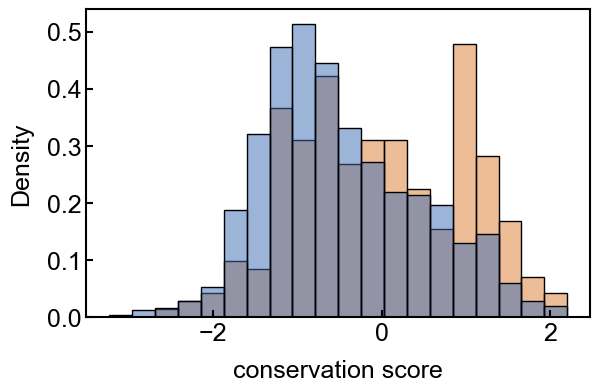

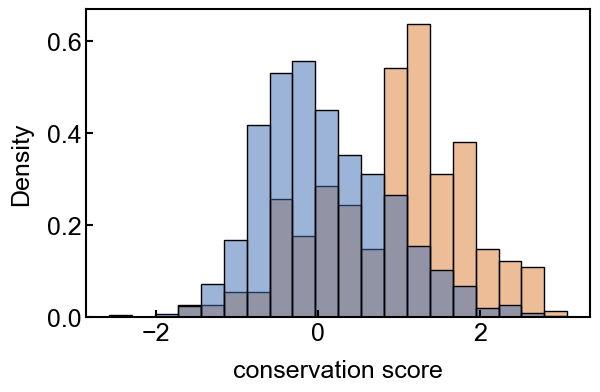

In [98]:
for i in temp['score_key'].unique():
    fig, ax = plt.subplots(figsize=(6.5, 4))
    sns.histplot(
        temp[temp['score_key']==i],
        x="conservation_score",
        hue="verified interaction",
        bins=20,
        stat="density",
        common_norm=False,
        ax=ax,
        legend=False,
    )
    ax.set_xticks([-2, 0, 2])
    ax.set_xlabel('conservation score')
    plt.savefig(f'./figure3/{i}_conservation_score_hist.png', bbox_inches='tight', dpi=300)
    # increase ymax by 0.1
    # ax.set_ylim(0, ax.get_ylim()[1]*1.1)

# basic score distributions vs. level

In [75]:
temp=pd.merge(z_long, score_key2, on='score_index', how='left')
temp = temp[(temp['rflank']!=5) & (temp['reciprocal_best_match']!=True)].copy()
temp = temp[temp['score_key'].isin(['aln_property_entropy', 'fragpair_gapless_lf0_rf0_edssmat50'])]
temp['reference_index'].value_counts().head(1)

reference_index
0    6
Name: count, dtype: int64

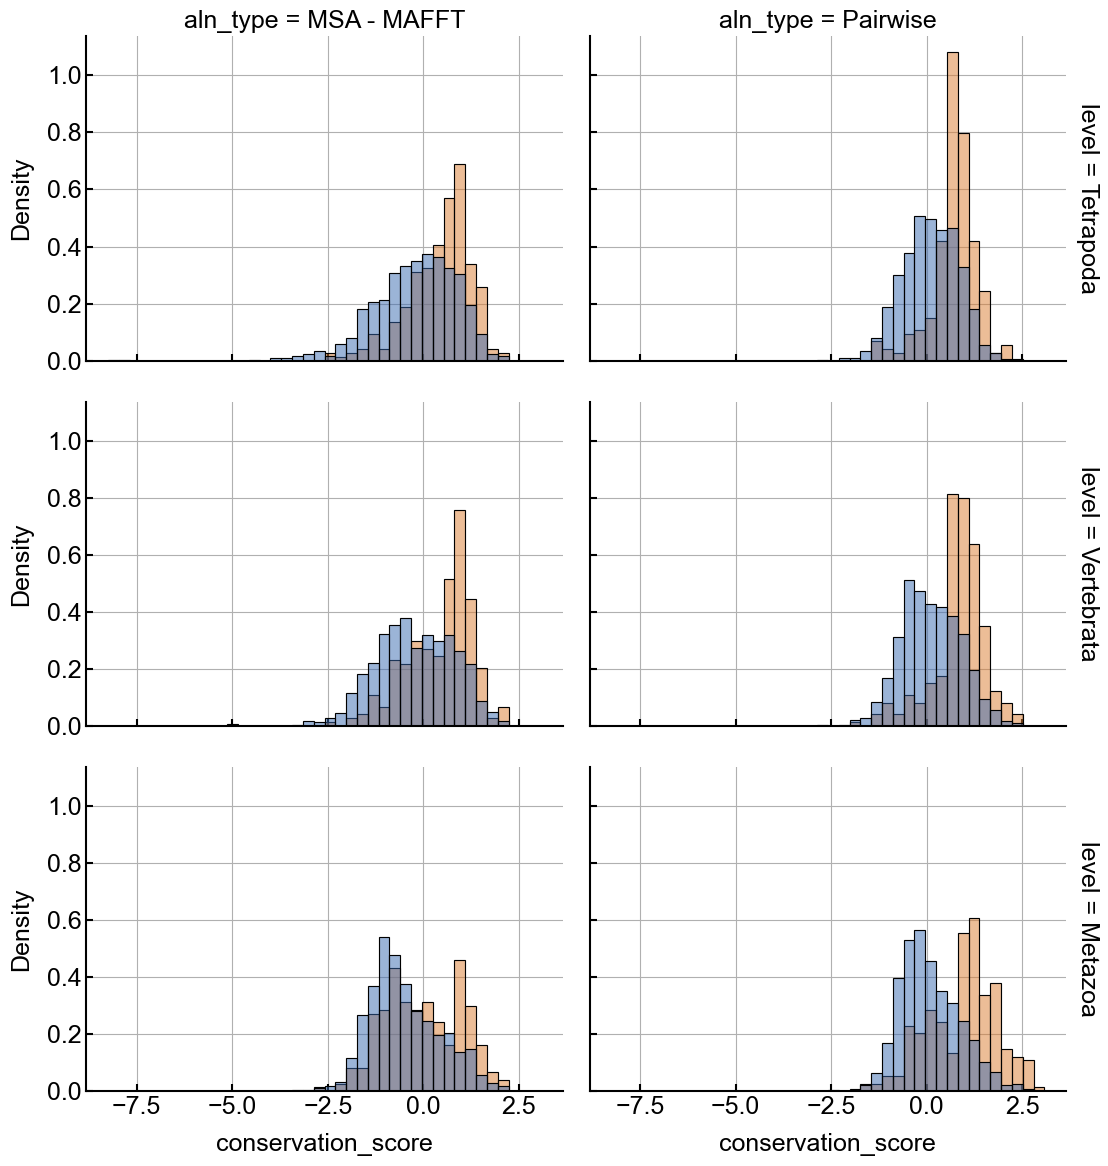

In [76]:
p = sns.displot(
    temp,
    x="conservation_score",
    hue="verified interaction",
    col="aln_type",
    row="level",
    bins=40,
    stat="density",
    common_norm=False,
    col_order=["MSA - MAFFT", "Pairwise"],#, "Pairwise embedding"],
    height=4,
    aspect=1.5,
    facet_kws=dict(margin_titles=True),
)
# plt.xlim([-3, 3])
p._legend.remove()
p.set_titles(f"Level: {{row_name}}\nAln type: {{col_name}}")
# show grid lines
for ax in p.axes.flat:
    ax.grid(True)
    ax.set_axisbelow(True)
output_folder = Path('./supplement/score_distributions')
output_folder.mkdir(parents=True, exist_ok=True)
# plt.savefig(output_folder / 'benchmark_score_distros_msa_v_pair.png', bbox_inches='tight', dpi=400)

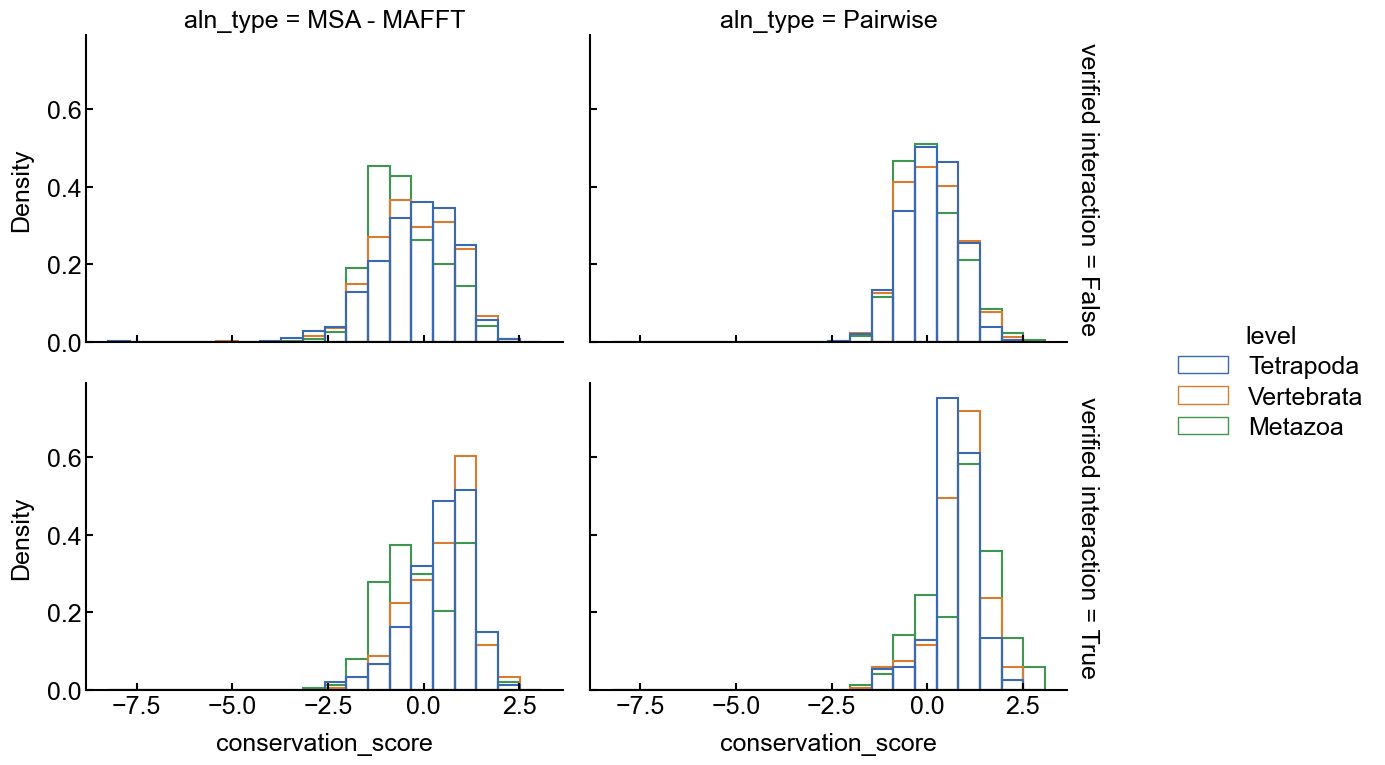

In [77]:
p = sns.displot(
    temp,
    x="conservation_score",
    hue="level",
    col="aln_type",
    row="verified interaction",
    bins=20,
    stat="density",
    common_norm=False,
    col_order=["MSA - MAFFT", "Pairwise"],#, "Pairwise embedding"],
    # row="columnwise_score_function_name",
    height=4,
    aspect=1.5,
    # multiple="stack",
    facet_kws=dict(margin_titles=True),
    legend=True,
    **dict(fill=False),
    # **dict(element='step'),
    # row_order=['Tetrapoda', 
)
# plt.xlim([-4, 4])
# p._legend.remove()
p.set_titles(f"Level: {{row_name}}\nAln type: {{col_name}}")
# show grid lines
# for ax in p.axes.flat:
#     ax.grid(True)
#     ax.set_axisbelow(True)

# auPRC dependence on variables - scoring matrix, flank size, columnwise score

In [45]:
score_key_filt = score_key[score_key['level'].isin(['Vertebrata'])].copy()
score_key_filt = score_key_filt[score_key_filt['similarity_threshold']!=0.5].copy()
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True)

In [46]:
score_indexes = list(score_key_filt.index)
zscores = import_multiple_scores(
    score_key_filt, score_indexes, filename_converter=table_file_converter
)
zscores['hit_length'] = zscores['hit_sequence'].apply(len)
zscores["ELM_motif_class"] = zscores["ELM_motif_class"].replace(
    "enah_LPPPP_FPPPP", "Ena/VASP ([FL]PPPP)"
)
zscores["mask_array"] = zscores.apply(
    lambda x: (
        position_weights[x["ELM_motif_class"]]
        if x["ELM_motif_class"] in position_weights
        else l14_weights[x["hit_length"]]
    ),
    axis=1,
)
l = len(zscores)
# starting with only the entries that are also present in the benchmark above
zscores=zscores[zscores['reference_index'].isin(passing_ref_id_list)].copy()
print(f'filtered out {l-len(zscores)} entries')
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

filtered out 731 entries
require all benchmark entries to have the other scores
 will drop:
49 entries
dropped 780 entries total


In [47]:
id_cols = [
    "reference_index",
    "ELM_motif_class",
    "verified interaction",
    "regex",
    "UniprotID",
    "name",
    "gene_id",
    "hit end position",
    "hit start position",
    "hit_sequence",
    "json_file",
    "hit_length",
    "mask_array",
]
z_long = zscores.melt(
    id_vars=id_cols,
    value_vars=score_indexes,
    var_name="score_index",
    value_name="z_scores",
)
z_long["masked_z_scores"] = z_long.apply(
    lambda x: extract_important_scores(x, "z_scores"), axis=1
)
z_long["conservation_score"] = z_long["masked_z_scores"].apply(np.mean)
z_long=z_long[z_long["ELM_motif_class"] != "TRAF6"]
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,mask_array,score_index,z_scores,masked_z_scores,conservation_score
20586,2571,Ena/VASP ([FL]PPPP),False,[FL]PPPP,B3KXY4,NaN,9606_0:000ad2,344,340,FPPPP,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5,"[1, 1, 0, 1, 1]",21.0,"[-0.6054451381712272, 0.8995474803387543, -0.3...","[-0.6054451381712272, 0.8995474803387543, 0.18...",0.013045
41685,129,LIG_AP2alpha_2,False,DP[FW],A0A1W2PQW2,NaN,9606_0:003a60,2280,2278,DPF,/home/jch/Documents/07-pt1_pt2_combined/benchm...,3,"[1, 1, 1]",32.0,"[-0.18221369154728193, -0.6785265733497383, -0...","[-0.18221369154728193, -0.6785265733497383, -0...",-0.447691
59146,1262,LIG_SH3_CIN85_PxpxPR_1,False,P.[AP].PR,A0A140VKG3,NaN,9606_0:000fb4,16,11,PPACPR,/home/jch/Documents/07-pt1_pt2_combined/benchm...,6,"[1, 0, 1, 0, 1, 1]",40.0,"[-0.6319360819381752, -1.0416979534978803, -0....","[-0.6319360819381752, -0.5871215846215668, -1....",-0.869484
55110,1443,DOC_WW_Pin1_4,True,...([ST])P.,Q61457,NaN,10090_0:0024c2,386,381,NRISPP,/home/jch/Documents/07-pt1_pt2_combined/benchm...,6,"[0, 0, 0, 1, 1, 0]",38.0,"[-1.529837754491915, -0.8419736040415555, 1.24...","[1.2389897046134108, 1.238989671997058]",1.238990
8750,583,LIG_EH_1,False,.NPF.,A0A024R258,NaN,9606_0:002430,147,143,SNPFG,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5,"[0, 1, 1, 1, 0]",16.0,"[-0.5540660783283982, -0.9366143221160625, 0.8...","[-0.9366143221160625, 0.8379717272591884, -0.8...",-0.300975


In [48]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key_filt, on='score_index', how='left')

In [49]:
auprc_df['score_key'].value_counts()

score_key
fragpair_gapless_lf5_rf5_edssmat50         28
fragpair_gapless_lf5_rf5_blosum62          28
fragpair_gapless_lf0_rf0_blosum62          28
fragpair_gapless_lf0_rf0_grantham          28
fragpair_gapless_lf2_rf2_edssmat50         28
fragpair_gapless_lf10_rf10_edssmat50       28
fragpair_gapless_lf0_rf0_edssmat50         28
frag_pairwise_gapless_embedding_lf5_rf5    14
frag_pairwise_gapless_embedding_lf0_rf0    14
aln_property_entropy                        7
aln_shannon_entropy                         7
Name: count, dtype: int64

In [87]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = auprc_df.copy()
temp = temp[(temp['aln_type']!='Pairwise embedding')&(temp['reciprocal_best_match'].isin([False, 'MSA', 'kibby']))].copy()
temp = temp[(temp['columnwise_score_function_name']!='shannon_entropy')&(~temp['score_key'].isin(['fragpair_gapless_lf5_rf5_blosum62', 'fragpair_gapless_lf0_rf0_blosum62', 'fragpair_gapless_lf0_rf0_grantham']))].copy()
temp['lflank'] = temp['lflank'].apply(lambda x: str(int(x)) if isinstance(x, float) else x)
temp['score_key'].value_counts()

score_key
aln_property_entropy                    7
fragpair_gapless_lf5_rf5_edssmat50      7
fragpair_gapless_lf2_rf2_edssmat50      7
fragpair_gapless_lf10_rf10_edssmat50    7
fragpair_gapless_lf0_rf0_edssmat50      7
Name: count, dtype: int64

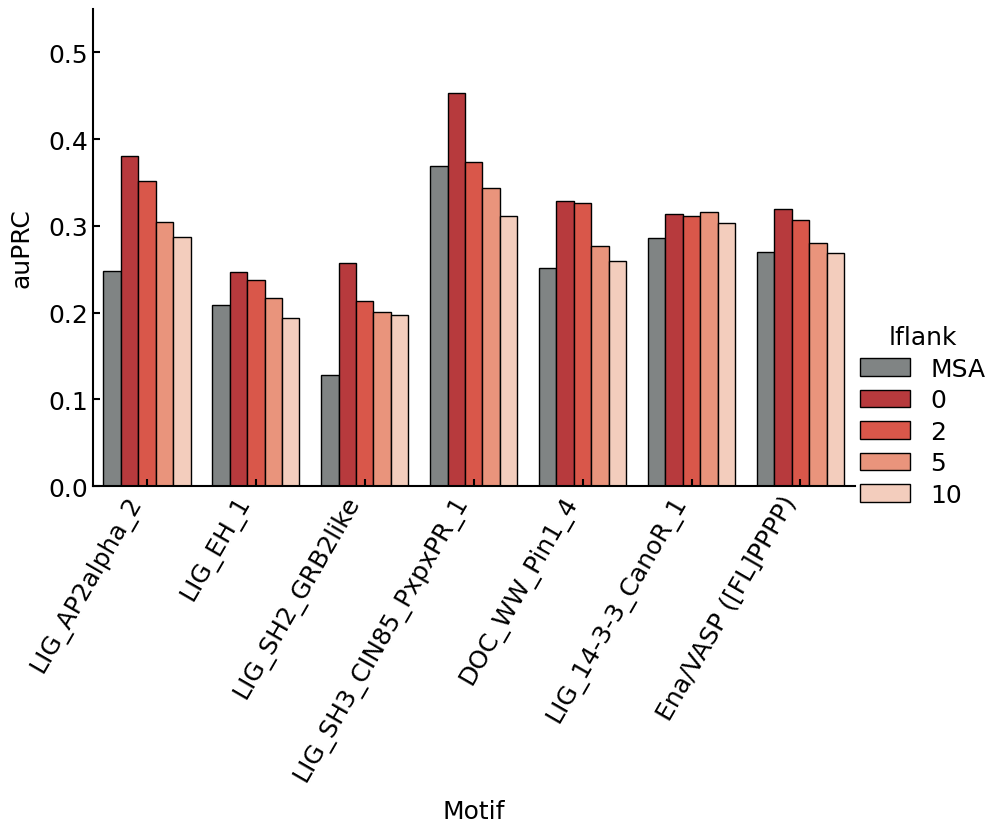

In [88]:

# temp = temp[(temp['columnwise_score_function_name']=='property_entropy')&(temp['reciprocal_best_match'].isin([False, 'MSA', 'kibby']))].copy()
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="lflank",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'MSA',
        '0',
        '2',
        '5',
        '10',
    ],
    palette={
        'MSA':'#7f8585',
        '0': '#cc2529',
        # '0': '#FCC9B4',
        '2': '#F14432',
        '5': '#FB8A6A',
        '10': '#FCC9B4',
        # '10': '#BB1419',
    },
)
plot.set(ylim=(0.0, 0.55))
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot._legend.remove()
plot.set_xlabels('Motif')
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'flank-PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

In [89]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = auprc_df.copy()
temp = temp[
    (temp["aln_type"] != "Pairwise embedding")
    & (temp["reciprocal_best_match"].isin([False, "MSA", "kibby"]))
].copy()
temp = temp[temp["columnwise_score_function_name"] != "shannon_entropy"].copy()
temp=temp[
    temp["score_key"].isin(
        [
            "fragpair_gapless_lf0_rf0_edssmat50",
            "fragpair_gapless_lf0_rf0_grantham",
            "fragpair_gapless_lf0_rf0_blosum62",
        ]
    )
].copy()

In [80]:
temp.score_key.value_counts()

score_key
fragpair_gapless_lf0_rf0_blosum62     7
fragpair_gapless_lf0_rf0_grantham     7
fragpair_gapless_lf0_rf0_edssmat50    7
Name: count, dtype: int64

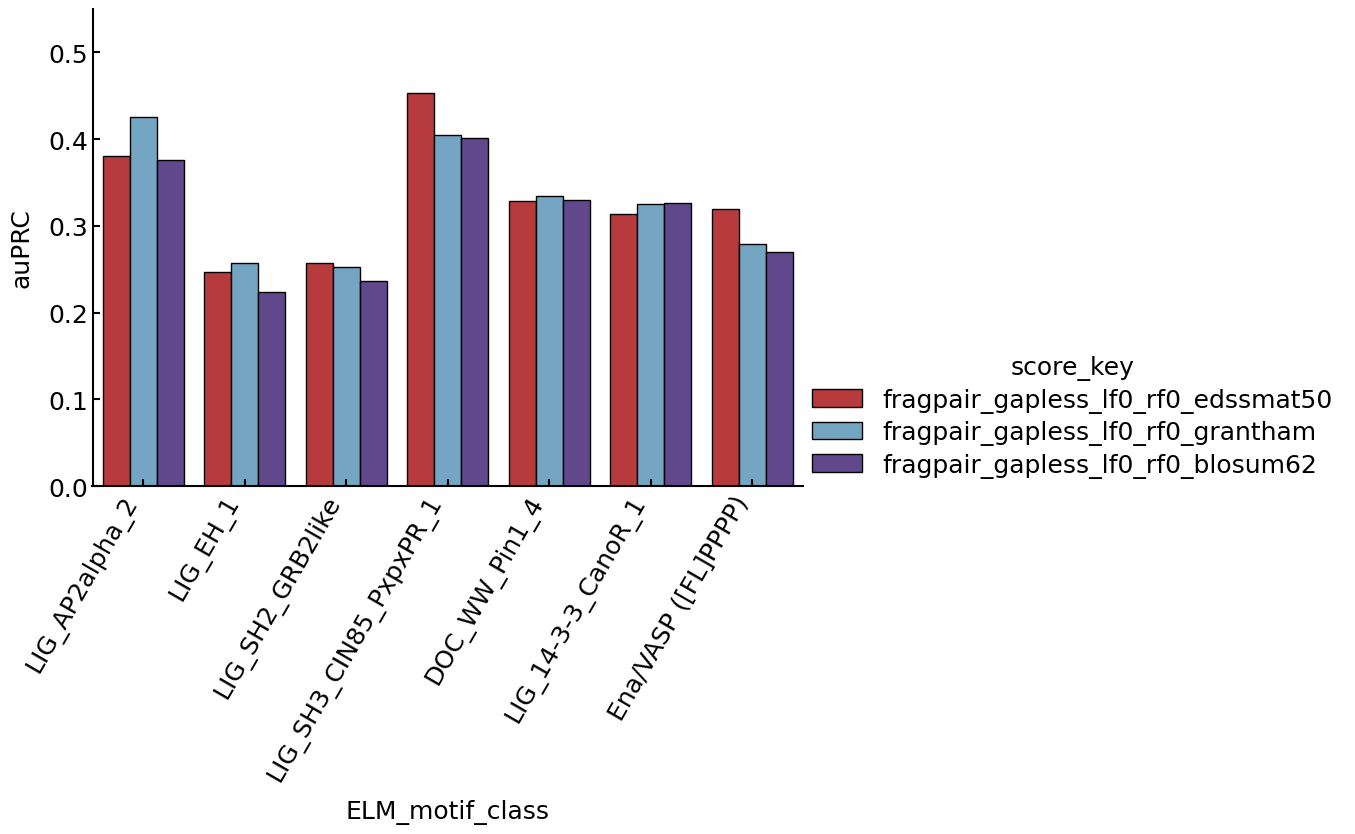

In [92]:
# fig, ax = plt.subplots(figsize=(10, 6))

plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    hue_order=[
        "fragpair_gapless_lf0_rf0_edssmat50",
        "fragpair_gapless_lf0_rf0_grantham",
        "fragpair_gapless_lf0_rf0_blosum62",
    ],
    palette={
        "fragpair_gapless_lf0_rf0_edssmat50":'#cc2529',
        "fragpair_gapless_lf0_rf0_grantham": '#67a9cf',
        # "fragpair_gapless_lf0_rf0_blosum62": '#ef8a62',
        "fragpair_gapless_lf0_rf0_blosum62": '#5e3c99',
    },
    kind="bar",
    height=6,
    aspect=1.5,
    legend=True,
    # ax=ax,
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plt.xticks(rotation=60, horizontalalignment="right")
# ax.set_ylim([0, 0.55])
# set y limits
plot.set(ylim=(0.0, 0.55))
# plot._legend.remove()
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'matrices-PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

In [105]:
temp = auprc_df.copy()
temp = temp[
    (temp["aln_type"] != "Pairwise embedding")
    & (temp["reciprocal_best_match"].isin([False, "MSA", "kibby"]))
].copy()
temp=temp[
    temp["score_key"].isin(
        [
            "fragpair_gapless_lf0_rf0_edssmat50",
            "aln_shannon_entropy",
            "aln_property_entropy",
        ]
    )
].copy()
temp['score_index'] = temp['score_index'].apply(lambda x: str(int(x)) if isinstance(x, float) else x)
temp.score_key.value_counts()

score_key
fragpair_gapless_lf0_rf0_edssmat50    14
aln_property_entropy                   7
aln_shannon_entropy                    7
Name: count, dtype: int64

In [106]:
temp

,ELM_motif_class,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,LIG_AP2alpha_2,2,0.248462,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
1,LIG_AP2alpha_2,3,0.260128,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2524
22,LIG_AP2alpha_2,34,0.400273,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,shannon_entropy,1.0,2706
29,LIG_AP2alpha_2,41,0.380148,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2706
34,LIG_EH_1,2,0.208653,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
35,LIG_EH_1,3,0.196494,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2524
56,LIG_EH_1,34,0.224186,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,shannon_entropy,1.0,2706
63,LIG_EH_1,41,0.247302,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2706
68,LIG_SH2_GRB2like,2,0.128279,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
69,LIG_SH2_GRB2like,3,0.117549,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,shannon_entropy,MSA,2524


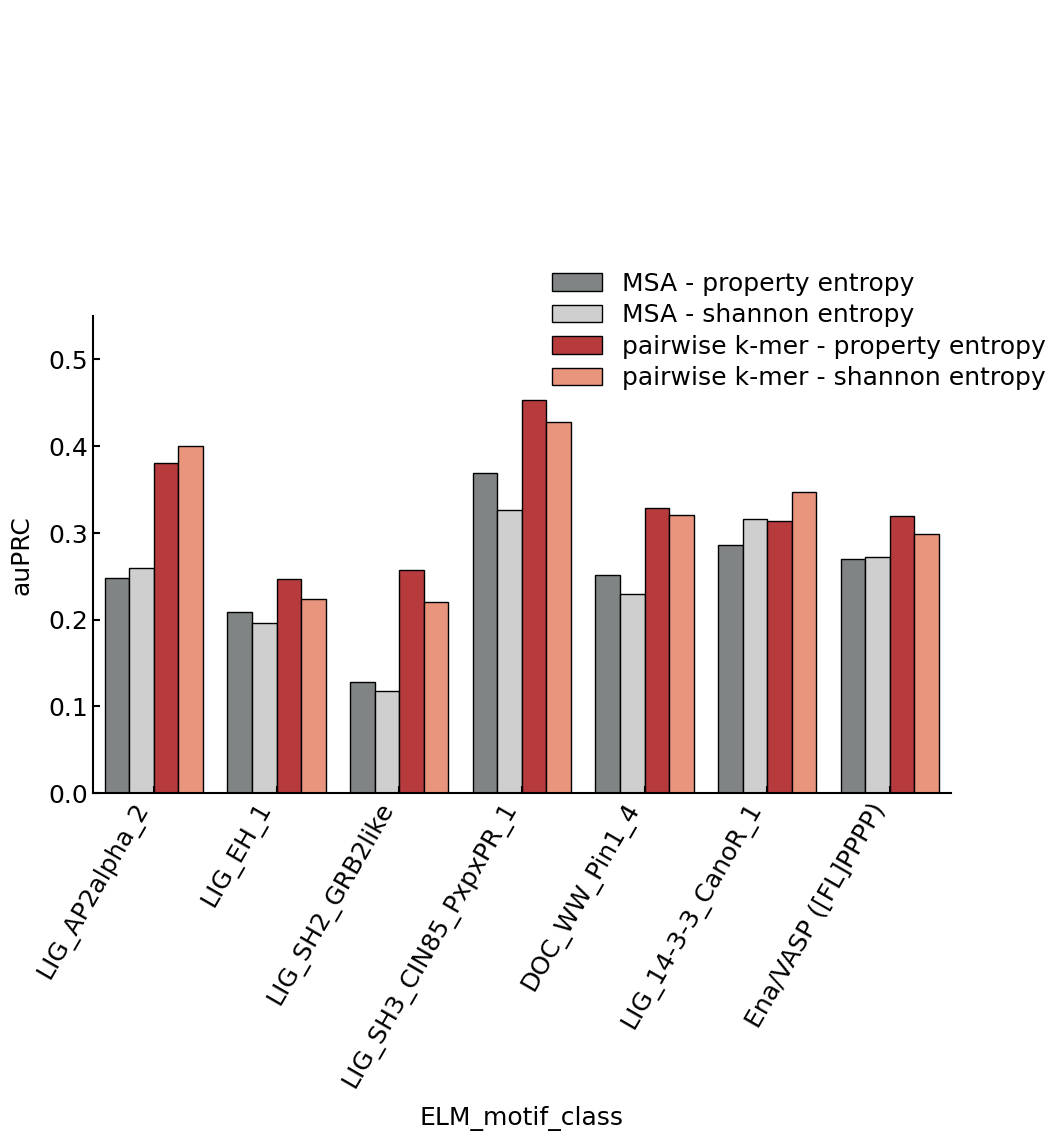

In [125]:
# fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_index",
    hue_order=['2', '3','41', '34'],
    palette={
        '2':'#7f8585',
        '3':'#cfcfcf',
        '41':'#cc2529',
        '34':'#FB8A6A',
        # "shannon_entropy": '#5e3c99',
        # "fragpair_gapless_lf0_rf0_blosum62": '#ef8a62',
    },
    kind="bar",
    height=6,
    aspect=1.5,
    legend=True,
    # ax=ax,
)

# set the legend labels
plot._legend.set_title('')
new_labels = ['MSA - property entropy', 'MSA - shannon entropy', 'pairwise k-mer - property entropy', 'pairwise k-mer - shannon entropy']
for t, l in zip(plot._legend.texts, new_labels): t.set_text(l)
# move the legend outside the plot
plot._legend.set_bbox_to_anchor((1, 1.35))
plt.tight_layout()


plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plt.xticks(rotation=60, horizontalalignment="right")
# ax.set_ylim([0, 0.55])
# set y limits
plot.set(ylim=(0.0, 0.55))
# plot._legend.remove()
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'shannon_v_PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

# auPRC - see `bootstrapping_auprc_scores.ipynb` for final plots

## general

In [45]:
score_inds, auprc_list = [], []
for i in z_long['score_index'].unique():
    df_filtered = z_long[z_long['score_index']==i].copy()
    assert df_filtered['reference_index'].duplicated().sum()==0, 'duplicates in reference index'
    prc_results = tools.df_2_precision_recall_curve(df_filtered, 'verified interaction', 'conservation_score')
    score_inds.append(i)
    auprc_list.append(prc_results[3])
general_auprc_df = pd.DataFrame({'score_index': score_inds, 'auPRC': auprc_list})

In [44]:
general_auprc_df=pd.merge(general_auprc_df, score_key2, on='score_index', how='left')

In [45]:
general_auprc_df

,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,0.0,0.224889,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2362
1,2.0,0.228150,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
2,4.0,0.210868,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2343
3,8.0,0.244820,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2445
4,9.0,0.268706,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2541
5,12.0,0.259915,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448
6,13.0,0.276281,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544
7,21.0,0.257537,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2602
8,27.0,0.289127,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2703
9,35.0,0.266125,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605


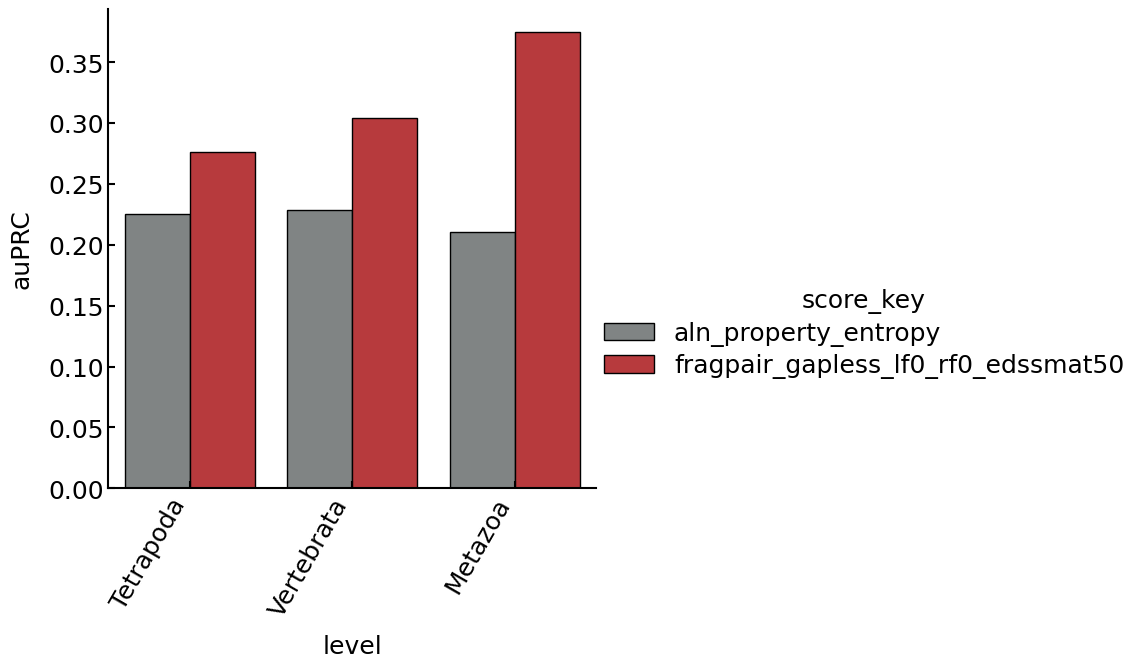

In [72]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
        & (general_auprc_df['reciprocal_best_match']!=True)
    ],
    y="auPRC",
    hue='score_key',
    x='level',
    kind='bar',
    aspect=1.2,
    height=6,
    hue_order=[
        'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        # 'frag_pairwise_gapless_embedding_lf0_rf0',
        # 'kibby',
    ],
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot.set(ylim=(0.0, 0.45))


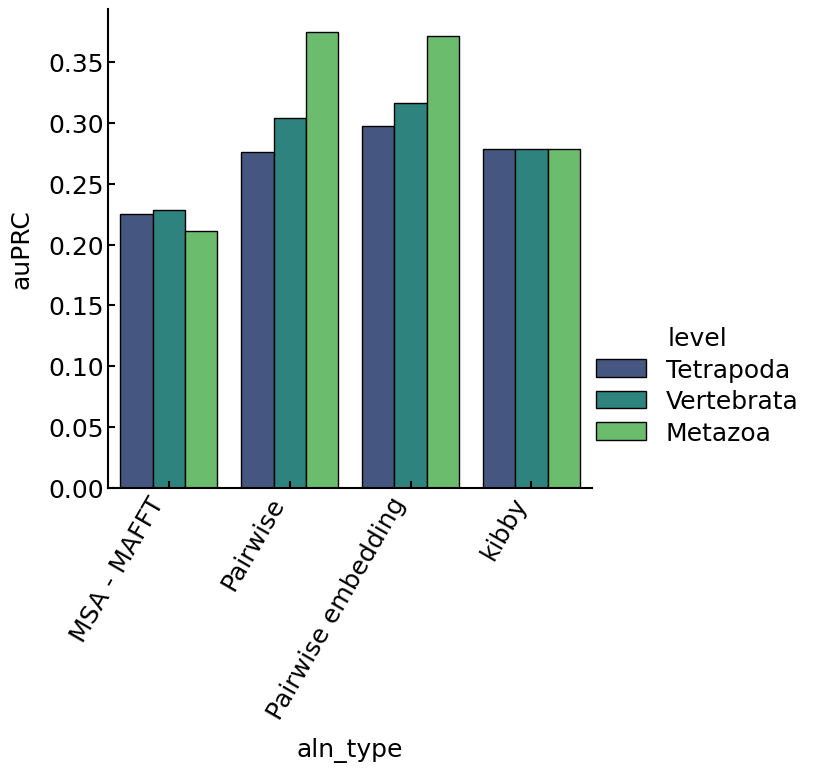

In [47]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
        & (general_auprc_df['reciprocal_best_match']!=True)
    ],
    y="auPRC",
    x='aln_type',
    hue='level',
    kind='bar',
    aspect=1.1,
    height=6,
    palette='viridis',
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")

## per class

In [46]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
scores = z_long['score_index'].unique()
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key2, on='score_index', how='left')

aln_df=auprc_df[auprc_df['aln_type']=='MSA - MAFFT'][["ELM_motif_class", "auPRC", "level"]].copy()
auprc_df_norm=pd.merge(auprc_df, aln_df, on=['ELM_motif_class', 'level'], how='left', suffixes=('', '_aln'))

auprc_df_norm["auPRC_diff"] = auprc_df_norm["auPRC"] - auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_increase"] = auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_log_increase"] = np.log10(
    auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
)
auprc_df_norm.tail(10)

,ELM_motif_class,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing,auPRC_aln,auPRC_diff,auPRC_increase,auPRC_log_increase
158,Ena/VASP ([FL]PPPP),49.0,0.299614,Pairwise,Metazoa,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723,0.238577,0.061037,1.255840,0.098934
159,Ena/VASP ([FL]PPPP),52.0,0.263915,Pairwise embedding,Tetrapoda,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448,0.267478,-0.003563,0.986680,-0.005824
160,Ena/VASP ([FL]PPPP),53.0,0.267287,Pairwise embedding,Tetrapoda,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544,0.267478,-0.000191,0.999287,-0.000310
161,Ena/VASP ([FL]PPPP),56.0,0.290489,Pairwise embedding,Vertebrata,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605,0.266770,0.023720,1.088915,0.036994
162,Ena/VASP ([FL]PPPP),57.0,0.290179,Pairwise embedding,Vertebrata,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2706,0.266770,0.023409,1.087751,0.036530
163,Ena/VASP ([FL]PPPP),60.0,0.332579,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2619,0.238577,0.094002,1.394014,0.144267
164,Ena/VASP ([FL]PPPP),61.0,0.310252,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723,0.238577,0.071676,1.300430,0.114087
165,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.368294,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.238577,0.129718,1.543715,0.188567
166,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.368294,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.267478,0.100817,1.376915,0.138907
167,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.368294,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.266770,0.101525,1.380571,0.140059


In [47]:
temp['ELM_motif_class'].unique()

array(['LIG_AP2alpha_2', 'LIG_EH_1', 'LIG_SH2_GRB2like',
       'LIG_SH3_CIN85_PxpxPR_1', 'DOC_WW_Pin1_4', 'LIG_14-3-3_CanoR_1',
       'Ena/VASP ([FL]PPPP)'], dtype=object)

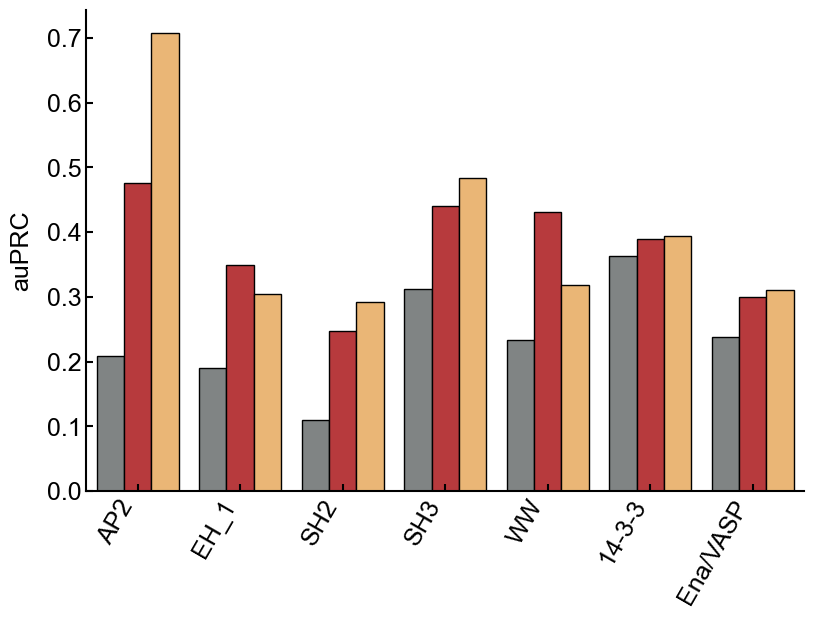

In [50]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
plt.rcParams['axes.labelsize'] = 18
temp = auprc_df_norm.copy()
temp = temp[(temp['level']=='Metazoa')&(temp['reciprocal_best_match'].isin([False, 'MSA', 'kibby']))].copy()
temp = temp[temp['rflank']!=5]
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('Ena/VASP ([FL]PPPP)', 'Ena/VASP')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_AP2alpha_2', 'AP2')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_EH_1', 'EH_1')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_SH2_GRB2like', 'SH2')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_SH3_CIN85_PxpxPR_1', 'SH3')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('DOC_WW_Pin1_4', 'WW')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_14-3-3_CanoR_1', '14-3-3')
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
        # 'kibby',
    ],
    # col="lflank",
    # row='level',
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
)
# make tick labels smaller
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot.set_xticklabels(rotation=60, horizontalalignment="right", fontsize=14)
# plot.set_yticklabels(fontsize=18)
plot._legend.remove()
plot.set_xlabels('')
# plt.ylim([0, 0.5])
# plt.tight_layout()
# plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)